# Gravity Wave workflow

Analyzing a data file from a gravity wave simulation/measurement.

In [1]:
%pylab inline
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy import constants as cons

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import pylab as plt
import cPickle as cP
from scipy.signal import medfilt

data = cP.load(open("gwave.pickle", "r"))
data.keys()

['h', 'hobs', 't']

In [3]:
data['hobs'].shape

(168000,)

In [4]:
data['t'].min(), data['t'].max()

(120.0, 155.0)

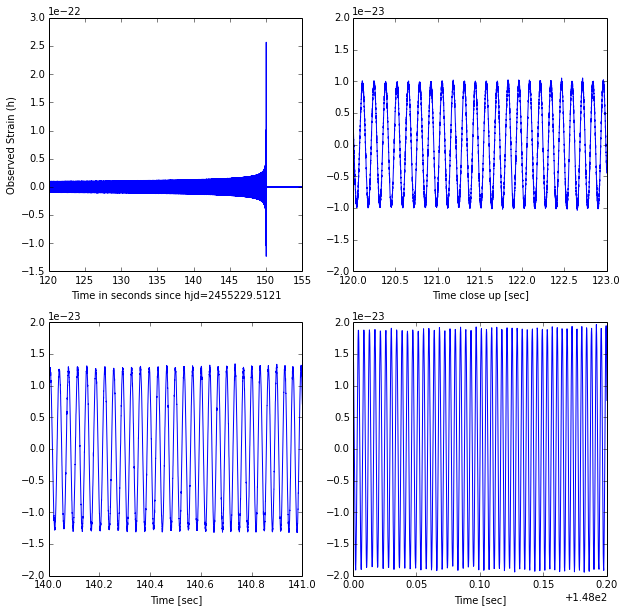

In [5]:
early = data["t"] < 123

# Create a 2x2 figure panel
f, ax = plt.subplots(2,2, figsize=(10,10))

# Top-left, full signal
ax[0,0].plot(data["t"],data["hobs"])
ax[0,0].set_xlabel("Time in seconds since hjd=2455229.5121")
ax[0,0].set_ylabel("Observed Strain (h)")

# Top-right, zoom into early part of the signal
ax[0,1].plot(data["t"][early],data["hobs"][early])
ax[0,1].set_xlabel("Time close up [sec]")
ax[0,1].set_ylim(-0.2e-22,0.2e-22)

# clean up the data
ax[1,0].plot(data["t"],data["hobs"])
ax[1,0].set_xlabel("Time [sec]")
ax[1,0].set_xlim(140,141)
ax[1,0].set_ylim(-0.2e-22,0.2e-22)

ax[1,1].plot(data["t"],data["hobs"])
ax[1,1].set_xlabel("Time [sec]")
ax[1,1].set_xlim(148,148.2)
ax[1,1].set_ylim(-0.2e-22,0.2e-22);

Now to model this, we grab the early-onset data and adjust it to be 0-offset, normalized to 1:

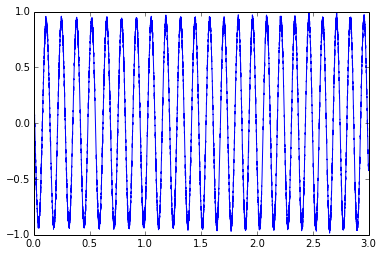

In [6]:
## get the data
tt = data["t"][early]
yy = data["hobs"][early]
tt -= tt.min()
yy /= yy.max()
plt.plot(tt, yy);

fmin: Uses a Nelder-Mead simplex algorithm to find the minimum of function of
one or more variables

In [7]:
from scipy.optimize import fmin

For a standard least-squares fit, we try to minimize the squared error function

$$||v(x)-y||_2^2$$

where we model our data as a simple sine function with unknown amplitude, frequency, phase and possibly an overall DC component, represented by the $p_i, i=0,...,3$ parameters:

$$ v(x) = p_0 + p_1\sin(\frac{2\pi x}{p_2}+p_3) $$

This leads to a model function:

$$ \sum_i (p_0 + p_1\sin(\frac{2\pi x_i}{p_2}+p_3) -y_i )^2 $$

In [8]:
def v(par, x):
    return par[0] + par[1]*np.sin(2*np.pi*x/par[2] + par[3])
    
def resid(par, x, y):
    return ((v(par, x) - y)**2).sum()

Which we can now minimize directly with `fmin`:

In [9]:
guess = np.array([yy.mean(), 10, .1, 1.0])
res = fmin(resid, guess, args=(tt,yy))

Optimization terminated successfully.
         Current function value: 2140.416216
         Iterations: 163
         Function evaluations: 279


Let's now evaluate our model function at our parameters and have a look:

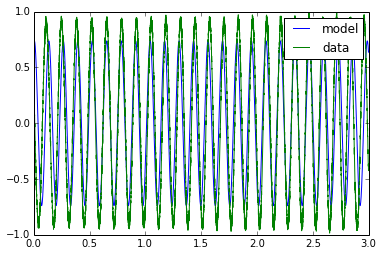

In [10]:
mdl = v(res, tt)
plt.plot(tt, mdl, label='model')
plt.plot(tt, yy, label='data');
plt.legend();

We can shift all the periods 

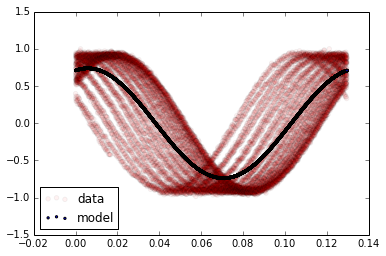

In [11]:
p = res[2]
t = tt % p
s = t.argsort()
plt.scatter(t[s], yy[s], c='r', alpha=0.05, label='data');
plt.scatter(t[s], mdl[s], marker='.', label='model')
plt.legend(loc='lower left');

Listening to a gravity wave:

In [12]:
from scipy.io import wavfile
#normalize the data
d = data["hobs"]
d /= max(d)/2**15.
trange = data["t"].max() - data["t"].min()
sample_rate = int(len(d)/trange)

In [13]:
wavfile.write("grav3.wav", sample_rate, d.astype(np.int16))

In [13]:
!play grav3.wav


grav3.wav:

 File Size: 336k      Bit Rate: 76.8k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 4800Hz       
Replaygain: off         
  Duration: 00:00:35.00  

In:100%  00:00:35.00 [00:00:00.00] Out:168k  [      |      ]        Clip:0    
Done.
